# Classification-based prediction of heart disease diagnoses

## Introduction
Heart disease is a significant global health concern, contributing to a substantial number of deaths each year. To address this issue effectively, it's crucial to develop accurate diagnostic tools.  In this project, we will employ classification techniques to predict the diagnosis of heart disease based on a variety of patient attributes.

**Research question:** Can we predict the diagnosis and severity of heart disease based on patient attributes such as age, resting blood pressure, cholesterol levels, and maximum heart rate achieved, while considering sex differences?

The dataset we will utilize is the UCI Heart Disease dataset, which comprises multivariate numerical data on various attributes of patients. It consists of 14 key attributes, including age, sex, chest pain type, etc. For this project, we will focus on a subset of attributes: 
- age
- resting blood pressure
- serum cholesterol
- maximum heart rate achieved

to predict the diagnosis of heart disease. We will filter the dataset to include only records from the Cleveland study origin to ensure consistency and relevance. By the end of this project, we aim to develop accurate predictive models for diagnosing heart disease based on patient attributes.

## Exploratory data analysis

In [15]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 5)
set.seed(69)

In [16]:
heart <- read_csv("https://raw.githubusercontent.com/chiefpat450119/dsci-project/main/data/heart_disease_uci.csv")

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We then filter the data to look at **only one location (Cleveland)** to reduce the effect of possible confounding variables introduced by the local environment.

In [17]:
cleveland_heart <- heart |>
filter(dataset == "Cleveland")

In order to use classification, we need to change the predicted variable (num) to a factor with more understandable levels. From the information presented in the dataset, num = 0 represents absence of disease, while num = 1, 2, 3, 4 represent stages of heart disease. The refactoring will be done based on the following interpretation:
- 0 = "none"
- 1 = "mild"
- 2 = "moderate"
- 3 = "severe"
- 4 = "critical"

In [18]:
heart_refactored <- cleveland_heart |>
mutate(disease = as_factor(num)) |>
mutate(disease = fct_recode(disease, "none" = "0", "mild" = "1", "moderate" = "2", "severe" = "3", "critical" = "4"))
heart_refactored

id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0,none
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2,moderate
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1,mild
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
303,38,Male,Cleveland,non-anginal,138,175,FALSE,normal,173,FALSE,0,upsloping,NA,normal,0,none
304,28,Male,Cleveland,atypical angina,130,132,FALSE,lv hypertrophy,185,FALSE,0,NA,NA,NA,0,none


We then split the data into a training and a testing set, making sure there are equal ratios of each disease classification in both sets. Let's take a look at how many cases are in each disease class, and then break it down by sex.

In [19]:
heart_split <- initial_split(heart_refactored, prop = 0.75, strata = disease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

In [20]:
heart_train_summary <- heart_train |>
group_by(disease) |>
summarize(count = n())
heart_train_summary

disease,count
<fct>,<int>
none,124
mild,41
moderate,26
severe,27
critical,8


In [21]:
options(repr.matrix.max.rows = 10)
heart_train_split <- heart_train |>
group_by(disease, sex) |>
summarize(count = n())
heart_train_split

`summarise()` has grouped output by 'disease'. You can override using the
`.groups` argument.


disease,sex,count
<fct>,<chr>,<int>
none,Female,52
none,Male,72
mild,Female,7
mild,Male,34
moderate,Female,5
moderate,Male,21
severe,Female,7
severe,Male,20
critical,Female,1


There is a difference in the distribution of cases between male and female patients. There is a significantly greater proportion of patients in the disease classes for male patients. This will need to be kept in mind for our analysis. Let's look at how our predictor variables correlate with heart disease.

$x
[1] "Age (years)"

$y
[1] "Resting Blood Pressure"

$colour
[1] "Disease diagnosis"

attr(,"class")
[1] "labels"

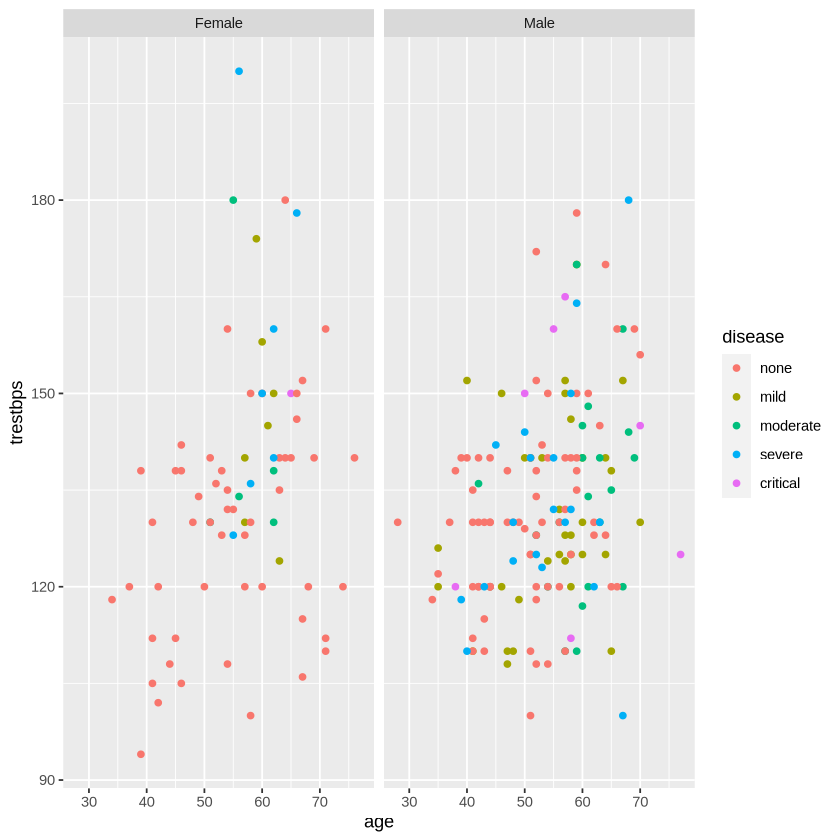

In [22]:
# TODO: Add Graphs with facet grid male and female, change classes to disease and no disease
heart_age_bp_plot <- ggplot(heart_train, aes(x = age, y = trestbps, color = disease)) +
geom_point() + 
facet_grid(cols = (vars(sex)))
labs(x = "Age (years)", y = "Resting Blood Pressure", color = "Disease diagnosis")
heart_age_bp_plot

# Methods
To conduct the data analysis for predicting the diagnosis of heart disease based on age, trestbps (resting blood pressure), cholesterol, and maximum heart rate achieved.

We chose the four predictors of age, trestbps, cholesterol, and maximum heart rate achieved out of the 16 columns, as they are the most effective at helping predict diagnoses. Furthermore, after removing the columns that contain class variables (fbs, restecg, exangslope, thal, num) and columns that contain large quantities of missing data (oldpeak, thalch, ca), we are left with these four variables.

Furthermore, we chose to split the male and female data as the observations for each differ greatly and it would not make sense to use both together to predict due to the variation. We also filtered for the Cleveland region as there might be confounding variables (external factors) that vary the data between regions, so focusing on one region will produce the best results.

To analyze this dataset, we need to preprocess the data, split the training and testing sets, the create a visualization to effectively communicate our findings

For data Preprocessing, we need to filter for the Cleveland area only, select the predictors we want to use, and deal with any N/A in the dataset. We then need to split the dataset into training and testing sets by choosing whether to use classification or regression, training models on the training set and evaluate their performance, using appropriate metrics like accuracy, precision, and recall, and summarizing the results for the male and female categories. Lastly, we need to visualize the results we find by creating 4 scatter plots consisting of - two for each gender - with two variables per scatterplot to showcase our findings for all four variables.

## Expected outcomes and significance
Based on the outlined methods, we expect to find predictive models capable of accurately diagnosing heart disease based on patient attributes like age, blood pressure, cholesterol, and maximum heart rate achieved. Such findings could lead to improved early detection and treatment, potentially reducing the burden of heart disease globally. Future questions may explore the effectiveness of these models across different demographics, as well as their integration into clinical practice for better patient outcomes.